In [1]:
!apt-get update && apt-get install libsm6 libxext6  -y
!apt-get install libgl1-mesa-glx -y

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease               
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [2]:
!pip install natsort
!pip install ipython-autotime
!pip install opencv-python
!pip install seaborn
!pip install scikit-learn
!pip install gradio==4.25.0

In [3]:
import os
import shutil
import PIL
import numpy as np
import cv2
import zipfile
from PIL import Image
import tensorflow as tf
import pandas as pd
import pathlib
import natsort
import gradio as gr

import matplotlib.pyplot as plt
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("gradio version:", gr.__version__)
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-05-06 03:39:01.876824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 03:39:01.877666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 03:39:01.878617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 03:39:01.888522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow version: 2.15.0
gradio version: 4.25.0
time: 1.37 ms (started: 2024-05-06 03:39:07 +00:00)


In [4]:
def dice_score(y_true, y_pred, threshold=0.5):
    smooth = 1.
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred >= threshold, [-1]), dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1. - dice_score(y_true, y_pred)
    return tf.cast(loss, dtype=tf.float32)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return tf.cast(bce, dtype=tf.float32) + dice

time: 1.04 ms (started: 2024-05-06 03:39:07 +00:00)


In [5]:
model_path = "/notebooks/saved_model/final/final_2_4block_RMSprop_swish+leakyrelu_CGAN_2000_clahe_generator.h5"
model = tf.keras.models.load_model(model_path,  
                                        custom_objects={'bce_dice_loss':bce_dice_loss,
                                                        'dice_score': dice_score})

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Quadro P5000, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2024-05-06 03:39:07.717897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 03:39:07.727928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 03:39:07.728212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

time: 3.04 s (started: 2024-05-06 03:39:07 +00:00)


In [6]:
def readImages(data, typeData):
    images = []
    height = int(256)
    width = int(512)
    for img in data:
        img = cv2.imread(str(img), 0)
        img = cv2.resize(img, (width, height))
        if typeData == "m":
            img = np.where(img > 0, 1, 0)
        img = np.expand_dims(img, axis=-1)
        images.append(img)
    print("(INFO..) Read Image Done")
    return np.array(images)

def normalizeImages(images):
    normalized_images = []
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(3, 3))
    height = int(256)
    width = int(512)
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (width, height))
        img = np.expand_dims(img, axis=-1)
        img = clahe.apply(img)
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255 
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
        normalized_images.append(img)
    print("(INFO..) Normalization Image Done")
    return np.array(normalized_images)

time: 1.25 ms (started: 2024-05-06 03:39:10 +00:00)


In [7]:
def predict(input_image):
    preprocessed_image = normalizeImages([input_image])
    segmented_image = model.predict(preprocessed_image)
    segmented_image = (segmented_image >= 0.5).astype('int')
    segmented_image = np.reshape(segmented_image, (256,512))
    segmented_image = (segmented_image * 255).astype('uint8')
    segmented_image = Image.fromarray(segmented_image)
    
    first_image = np.reshape(preprocessed_image, (256,512))
    first_image = (first_image * 255).astype('uint8')
    first_image = Image.fromarray(first_image)
    
    # overlay_image = np.where(segmented_image >= 0.5, 1, 0)
    final_output = Image.blend(first_image, segmented_image, 0.6)

    return [segmented_image, final_output]

time: 1.13 ms (started: 2024-05-06 03:39:10 +00:00)


(INFO..) Normalization Image Done


2024-05-06 03:39:12.916342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-06 03:39:13.554854: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-05-06 03:39:13.562837: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-05-06 03:39:13.569216: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-05-06 03:39:13.570542: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 6s 6s/step


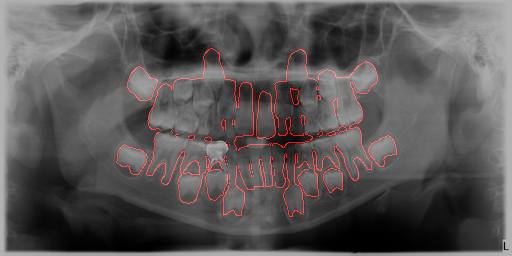

time: 5.72 s (started: 2024-05-06 03:39:10 +00:00)


In [8]:
#canny method
input_image = Image.open("/notebooks/Childrens dental segmentation dataset version 2/images/image_1.png")
segmented_image = np.array(input_image)
segmented_image = normalizeImages([segmented_image])

segmented_image = model.predict(segmented_image)
segmented_image = (segmented_image >= 0.5).astype('int')
segmented_image = np.reshape(segmented_image, (256,512))
segmented_image = (segmented_image * 255).astype('uint8')
canny = cv2.Canny(segmented_image, 100, 200)
kernel = np.ones((1,1), np.uint8) 

dilated_image = cv2.dilate(canny, kernel, iterations=2)
background_image = input_image.resize((512, 256))
background_image = np.array(background_image)
foreground = np.zeros_like(background_image)
foreground[dilated_image == 255] = [255, 0, 0]
result = cv2.addWeighted(background_image, 0.7, foreground, 1, 0)

#show image
result = Image.fromarray(result)
result.show()

(INFO..) Normalization Image Done
1/1 [==============================] - 0s 35ms/step


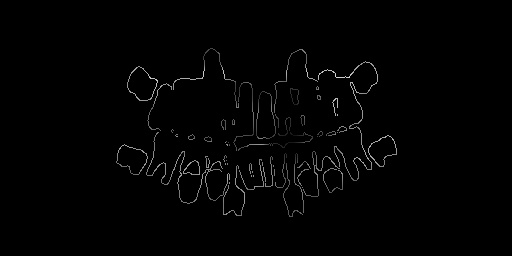

time: 226 ms (started: 2024-05-06 03:39:16 +00:00)


In [9]:
#smoothing
input_image = Image.open("/notebooks/Childrens dental segmentation dataset version 2/images/image_1.png")
segmented_image = np.array(input_image)
segmented_image = normalizeImages([segmented_image])

segmented_image = model.predict(segmented_image)
segmented_image = (segmented_image >= 0.5).astype('int')
segmented_image = np.reshape(segmented_image, (256,512))
segmented_image = (segmented_image * 255).astype('uint8')

edges = cv2.Canny(segmented_image, 100, 200)

input_image = input_image.resize((512, 256))
input_image = np.array(input_image)

mask = np.zeros_like(input_image)
mask[edges != 0] = 255
blurred = cv2.GaussianBlur(input_image, (5, 5), 0)
sharpened = cv2.addWeighted(blurred, 1.5, input_image, -0.5, 0)
result = cv2.bitwise_and(sharpened, mask)

#show image
result = Image.fromarray(result)
result.show()

(INFO..) Normalization Image Done


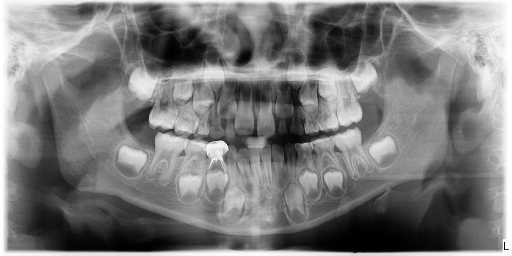

time: 77 ms (started: 2024-05-06 03:39:16 +00:00)


In [10]:
input_image = Image.open("/notebooks/Childrens dental segmentation dataset version 2/images/image_1.png")
input_image = np.array(input_image)
input_image = normalizeImages([input_image])
input_image = np.reshape(input_image, (256,512))
input_image = (input_image * 255).astype('uint8')
input_image = Image.fromarray(input_image)
input_image.show()

In [ ]:
output_images = [gr.Image(label=f"Output {i+1}") for i in range(2)]


gr.Interface(
    fn=predict,
    inputs=gr.Image(),
    outputs=output_images,
).launch(debug=True, share=True)

# demo = gr.Interface(predict, gr.Image(), "image")
# demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://5c5bab63ca728ed3e8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
